In [ ]:
import torch

In [ ]:
from torch.autograd.functional import jacobian, hessian

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
import numpy as np
from scipy.special import logit, expit
from scipy.stats import norm
from tqdm.notebook import tqdm



#**Feed-forward Network Functions**

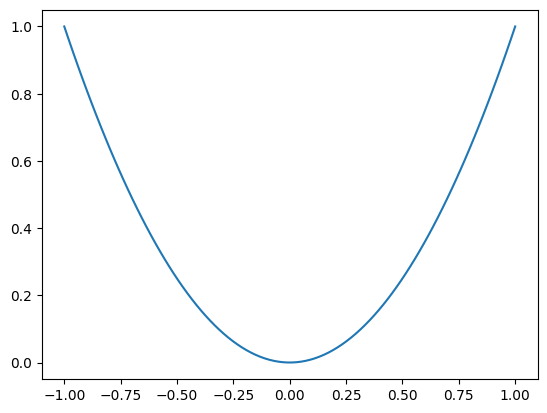

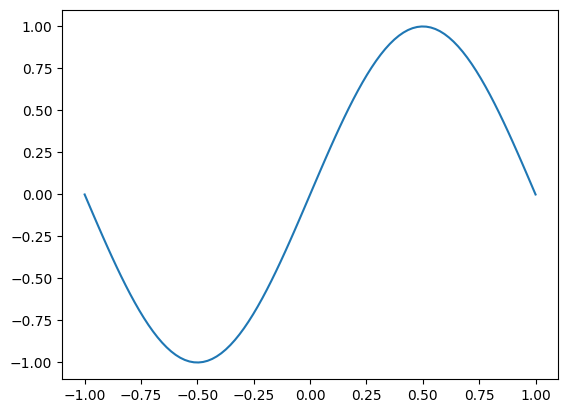

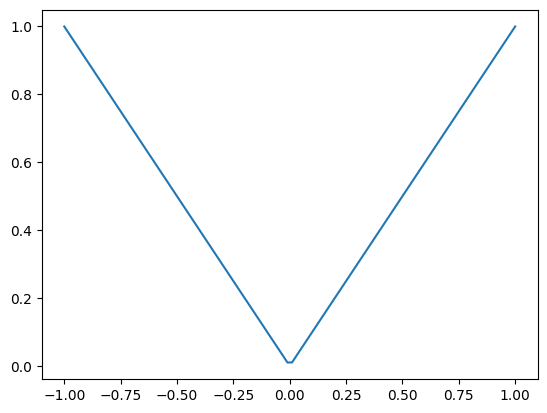

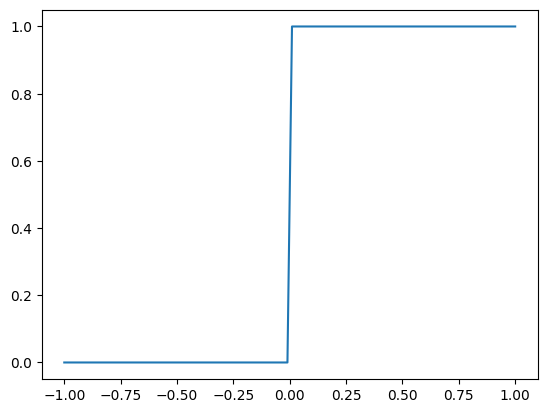

In [ ]:
def func1(x):
  return x ** 2

def func2(x):
  return np.sin(np.pi * x)

def func3(x):
  return np.abs(x)

def func4(x):
  return 0.5 * (np.sign(x) + 1)

def func5(x):
  return x ** 3

def func6(x):
  return x

functions = [func1, func2, func3, func4]

for i in range(0, 4):
  x_train = np.linspace(-1, 1, 100)
  y_train = functions[i](x_train)
  plt.figure(i)
  plt.plot(x_train, y_train)


#*Forward Propogation*

$x_i → (w_{ji}) → a_j → (activation func) → z_j → (w_{kj}) → y$

$a_j = \sum_{i=0}^{D} w_{ji} x_i$

$z_j = h(a_j)$

$y_k = \sum_{j=0}^{M} w_{kj} z_j$

#*Back Propogation*

$δ_k = y_k - t_k$

$\delta_j = h'(a_j)\sum_{k=1}^{K} w_{kj}\delta_k$

$\frac{\delta E_n}{\delta w_{ji}} = \delta_j x_i$

$\frac{\delta E_n}{\delta w_{kj}} = \delta_k z_j$

In [ ]:
targetFunc = func1



def tanh(x):
  return ( np.e ** x - np.e ** -x ) / ( np.e ** x + np.e ** -x )

def getTanhDerivative(x):
  return 1 - tanh(x)**2

# x = np.linspace(-5, 5, 100)
# plt.plot(x, tanh(x))


wji = np.random.randn(4, 2) / 4
wkj = np.random.randn(1, 4) / 4
alpha = 0.01

def forward_prop(xi, wji, wkj):
  xi = np.r_[[[1]], xi]
  aj = wji @ xi
  zj = np.tanh(aj)
  y = wkj @ zj

  return xi, zj, y[0][0]

def calc_grad(xi, zj, y, tn):
  delta_k = y - tn    # number
  delta_j = getTanhDerivative(zj.T) * (wkj * delta_k).sum()   # 1 * 4
  grad_wji = xi @ delta_j # 2 * 1  @  1 * 4  =  2 * 4
  grad_wkj = delta_k * zj # 4 * 1
  return grad_wji, grad_wkj


  delta_k = y - tn    # number
  delta_j = getTanhDerivative(zj.T) * (wkj * delta_k).sum()   # 1 * 4
  grad_wji = xi @ delta_j # 2 * 1  @  1 * 4  =  2 * 4
  grad_wkj = delta_k * zj # 4 * 1
  return grad_wji, grad_wkj


iters = 1
sample_size = 1
datas = np.linspace(-1, 1, sample_size)
for iter in range(0, iters):
  np.random.shuffle(datas)
  for i in range(0, sample_size):
    data = np.array([[datas[i]]]).T
    t = targetFunc(data)
    xi, zj, y = forward_prop(data, wji, wkj)
    print(xi) # 2 * 1
    print(zj) # 4 * 1
    print(y)  # number
    gradji, gradkj = calc_grad(xi, zj, y, t)
    wji -= alpha * gradji.T
    wkj -= alpha * gradkj.T

print(gradji)
print(gradkj)
print(wji)
print(wkj)



xs = np.linspace(-1, 1, 100)
for i in range(0, 100):
  x = np.array([[xs[i]]]).T
  a, b, y = forward_prop(x, wji, wkj)
  plt.scatter(x, y)


x_train = np.linspace(-1, 1, 100)
y_train = targetFunc(x_train)
plt.plot(x_train, y_train)

#**Jacobian Matrix**

# multidata calculation example

Simple Example: a = w @ x

The shape of jacobian matrix is: output.shape() * input.shape()

If we have:

input : 2 * 5 (5 pieces of data)

w   : 3 * 2 (expand dimension from 2 to 3)

output : 3 * 5

Consider output as 3 groups. Each group containing 5 elements.

First we consider the groups. As there are 3 groups to calculate, our jacobian will also yield 3 groups. That's why the first dimension is 3.

Second, we consider the 5 elements in each group. Remember that the first dimension 3 comes from multiplying w with input. So each group corresponds to one of the three groups (of size 2) in w. Thus when calculating we can ignore unrelated w groups. For the 5 elements, we will calculate the jacobian for each of them with respect to input. Thus, there will be a smaller jacobian matrix of shape 2 * 5 (the same as input) for each of the 5 elements. Therefore, the final jacobian matrix will have shape 3 * 5 * 2 * 5.

Third, let's sondier the 2 * 5 smaller jacobians. Let's seperated them into 2 groups. Each group is multiplied by one column of w. Thus, we only consider one column w that corresponds to each of the 2 groups.

Finally, for the 5 elements in the 2 groups, we need to turn back to the 5 elements in the output. Each 1 element of the input group corresponds to 1 element of the output group. Thus, every off diagonal elements, which don't corresponds to each other, are 0. Those non zero elements are w[element][group]

In [ ]:
xi = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0], [1.0, 2.0, 3.0, 4.0, 5.0]], requires_grad=True)
wji = torch.rand(3, 2)
aj = wji @ xi
print(xi)
print(wji)
print(aj)

def forward(x):
  return wji @ x

j = jacobian(forward, xi)
print(j)
print(j.shape)

my_j = torch.rand(aj.shape[0], aj.shape[1], xi.shape[0], xi.shape[1])
for a in range(aj.shape[0]):
  for b in range(aj.shape[1]):
    for c in range(xi.shape[0]):
      for d in range(xi.shape[1]):
        if b != d:
          my_j[a][b][c][d] = 0
        else:
          my_j[a][b][c][d] = wji[a][c]
print(my_j)


Complex Example: y = w @ h(x)

In [ ]:
def tanh(x):
  return (np.e**x-np.e**-x)/(np.e**x+np.e**-x)

def getTanhDerivative(x):
  return 1-tanh(x)**2

xi = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0], [1.0, 2.0, 3.0, 4.0, 5.0]], requires_grad=True)
wji = torch.rand(3, 2)
aj = wji @ xi
zj = tanh(aj)
print(xi)
print(wji)
print(aj)
print(zj)

def forward(x):
  return tanh(wji @ x)

j = jacobian(forward, xi)
print(j)
print(j.shape)

my_j = torch.rand(zj.shape[0], zj.shape[1], xi.shape[0], xi.shape[1])
for a in range(zj.shape[0]):
  for b in range(zj.shape[1]):
    for c in range(xi.shape[0]):
      for d in range(xi.shape[1]):
        if b != d:
          my_j[a][b][c][d] = 0
        else:
          my_j[a][b][c][d] = wji[a][c] * getTanhDerivative(aj[c][d])
print(my_j)


# In neural network

Output error E always has shape 1. So the jacobian, or gradient with respect to w, always matches itself in shape.

# $\frac{\delta E}{\delta w_{ji}} = \frac{\delta E}{\delta a_k} \frac{\delta a_k}{\delta a_l} \frac{\delta a_l}{\delta a_j} \frac{\delta a_j}{\delta w_{ji}}$

$a_k$ is the output because there is no activation function in the last layer.

In [ ]:
def tanh(x):
  return (np.e**x-np.e**-x)/(np.e**x+np.e**-x)

def getTanhDerivative(x):
  return 1-tanh(x)**2

aj = torch.rand(3, requires_grad=True)
zj = tanh(aj)
wlj = torch.rand(5, 3, requires_grad=True)
al = wlj @ zj



# Use Pytorch
# dal_daj
# al = wlj @ h(aj)
def func(aj):
  return wlj @ tanh(aj)
j1 = jacobian(func, aj)

# dal_dwlj
# al = wlj @ zj
def func(wlj):
  return wlj @ zj
j2 = jacobian(func, wlj)




# Make our own function
def getJacobians(al, zj, aj, wlj):
  # there is no ai in the first layer
  if aj != None:
    dal_daj = torch.rand(al.shape[0], aj.shape[0])
    for l in range(al.shape[0]):
      for j in range(aj.shape[0]):
        dal_daj[l][j] = wlj[l][j] * getTanhDerivative(aj[j])
  else:
    dal_daj = None

  dal_dwlj = torch.rand(al.shape[0], wlj.shape[0], wlj.shape[1])
  for l in range(al.shape[0]):
    for l_ in range(wlj.shape[0]):
      for j in range(wlj.shape[1]):
        if (l == l_):
          dal_dwlj[l][l_][j] = zj[j]
        else:
          dal_dwlj[l][l_][j] = 0
  return dal_daj, dal_dwlj

dal_daj, dal_dwlj = getJacobians(al, zj, aj, wlj)

print(j1)
print(dal_daj)

print(j2)
print(dal_dwlj)

tensor([[0.2489, 0.2697, 0.4970],
        [0.5064, 0.1606, 0.2253],
        [0.1823, 0.2404, 0.4281],
        [0.0965, 0.7507, 0.4635],
        [0.3904, 0.9215, 0.4926]])
tensor([[0.2489, 0.2697, 0.4970],
        [0.5064, 0.1606, 0.2253],
        [0.1823, 0.2404, 0.4281],
        [0.0965, 0.7507, 0.4635],
        [0.3904, 0.9215, 0.4926]], grad_fn=<CopySlices>)
tensor([[[0.6818, 0.2600, 0.5253],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.6818, 0.2600, 0.5253],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.6818, 0.2600, 0.5253],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],


In [ ]:
def targetFunc(x):
  return 1 / (1 + np.e**(-x))

# 1 -> 5 -> 3 -> 1
z = torch.linspace(-1, 1, 6, requires_grad=True).unsqueeze(1)
zi = z[0]
tk = targetFunc(zi)

wji = torch.rand(5, 1, requires_grad=True)
wlj = torch.rand(3, 5, requires_grad=True)
wkl = torch.rand(1, 3, requires_grad=True)

aj = wji @ zi
zj = tanh(aj)

al = wlj @ zj
zl = tanh(al)

ak = wkl @ zl
E = 1/2 * (ak - tk).pow(2)

# Use pytorch
E.backward(torch.ones_like(E))
print(wji.grad)
print(wlj.grad)
print(wkl.grad)

# Use our own jacobian
dE_dak = ak - tk

_   , daj_dwji = getJacobians(aj, zi, None, wji)
dal_daj, dal_dwlj = getJacobians(al, zj, aj, wlj)
dak_dal, dak_dwkl = getJacobians(ak, zl, al, wkl)

dE_dwji = dE_dak @ dak_dal @ dal_daj @ daj_dwji
dE_dwlj = dE_dak @ dak_dal @ dal_dwlj
dE_dwkl = dE_dak @ dak_dwkl
print(dE_dwji)
print(dE_dwlj)
print(dE_dwkl)

torch.Size([5])
tensor([[0.1196],
        [0.3986],
        [0.2181],
        [0.3180],
        [0.2479]])
tensor([[0.1466, 0.0828, 0.1140, 0.0344, 0.1201],
        [0.1859, 0.1050, 0.1445, 0.0437, 0.1522],
        [0.2075, 0.1173, 0.1614, 0.0487, 0.1700]])
tensor([[1.6006, 1.6309, 0.9660]])
tensor([[0.1196],
        [0.3986],
        [0.2181],
        [0.3180],
        [0.2479]], grad_fn=<UnsafeViewBackward0>)
tensor([[0.1466, 0.0828, 0.1140, 0.0344, 0.1201],
        [0.1859, 0.1050, 0.1445, 0.0437, 0.1522],
        [0.2075, 0.1173, 0.1614, 0.0487, 0.1700]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[1.6006, 1.6309, 0.9660]], grad_fn=<UnsafeViewBackward0>)


Let's make a neural network

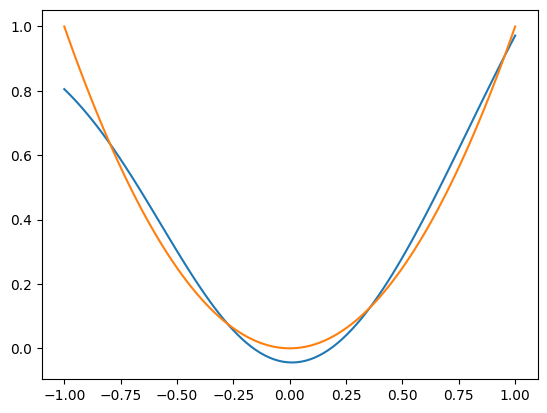

In [ ]:
class Network1:
  def __init__(self, layerShapes):
    self.parameters = []
    for i in range(len(layerShapes) - 1):
      self.parameters.append(torch.rand(layerShapes[i+1], layerShapes[i], requires_grad=False))
    # store:
    # aj, zi, None, wji
    # al, zj, aj, wlj
    # ak, zl, al, wkl
    self.store = np.zeros((len(self.parameters), 4)).tolist()
    self.alpha = 0.05

  def forward(self, xi):
    for i in range(0, len(self.parameters)):
      w = self.parameters[i]
      self.store[i][3] = w

      if (i == 0):
        self.store[i][2] = None
        self.store[i][1] = xi
      else:
        self.store[i][2] = self.store[i-1][0]
        self.store[i][1] = tanh(self.store[i][2])
      self.store[i][0] = w @ self.store[i][1]
    return self.store[-1][0]

  def backward(self, dE_da):
    dE_dw = None
    dE_da = dE_da
    for i in range(0, len(self.store)):
      i = len(self.store) - i - 1

      da_da, da_dw = getJacobians(self.store[i][0], self.store[i][1], self.store[i][2], self.store[i][3])
      dE_dw = dE_da @ da_dw
      if (da_da != None):
        dE_da = dE_da @ da_da
      self.parameters[i] -= self.alpha * dE_dw

# biased
# 2 -> 4 -> 1
n = Network1([2, 4, 1])
def targetFunc(x):
  return x ** 2
train_size = 100
x_train = torch.linspace(-1, 1, train_size).unsqueeze(1)
y_train = targetFunc(x_train)
iters = 100
for iter in range(0, iters):
  for i in range(0, x_train.shape[0]):
    x = torch.tensor([1, x_train[i]])
    y = y_train[i]
    pred = n.forward(x)
    n.backward(pred - y)
x_test = torch.cat((torch.ones_like(x_train), x_train), axis=1)
plt.plot(x_train, n.forward(x_test.t()).t())
plt.plot(x_train, targetFunc(x_train))

#**Hessian**

In [ ]:
def tanh(x):
  return (np.e**x-np.e**-x)/(np.e**x+np.e**-x)

def getTanhDerivative(x):
  return 1-tanh(x)**2

wkl = torch.rand(1, 3, requires_grad=True)

al = torch.rand(3, requires_grad=True)
zl = tanh(al)
ak = wkl @ zl
tk = torch.rand(1, requires_grad=True)
E = 0.5 * (tk - ak).pow(2)
print(E)

def func(al):
  return 0.5 * (tk - wkl @ tanh(al)).pow(2)
j1 = hessian(func, al)

def func(ak):
  return 0.5 * (tk - ak).pow(2)
j2 = hessian(func, ak)

def func(wkl):
  return (tk - wkl @ tanh(al)).pow(2)
j3 = hessian(func, wkl)

print(zl)
# def getJacobians(zl, al, zj, wlj):
#   dzl_dzj = torch.rand(zl.shape[0], zj.shape[0])
#   for l in range(zl.shape[0]):
#     for j in range(zj.shape[0]):
#       dzl_dzj[l][j] = wlj[l][j] * getTanhDerivative(al[l])

#   dzl_dwlj = torch.rand(zl.shape[0], wlj.shape[0], wlj.shape[1])
#   for l in range(zl.shape[0]):
#     for l_ in range(wlj.shape[0]):
#       for j in range(wlj.shape[1]):
#         if (l == l_):
#           dzl_dwlj[l][l_][j] = zj[j] * getTanhDerivative(al[l])
#         else:
#           dzl_dwlj[l][l_][j] = 0
#   return dzl_dzj, dzl_dwlj

# dzl_dzj, dzl_dwlj = getJacobians(zl, al, zj, wlj)

print(j1)
# print(dzl_dzj)

print(j2)
print(j3)
# print(dzl_dwlj)

tensor([0.0789], grad_fn=<MulBackward0>)
tensor([0.5793, 0.6890, 0.0726], grad_fn=<DivBackward0>)
tensor([[-0.0074,  0.2085,  0.0620],
        [ 0.2085, -0.0365,  0.0657],
        [ 0.0620,  0.0657,  0.0115]])
tensor([[1.]])
tensor([[[[0.6712, 0.7983, 0.0841]],

         [[0.7983, 0.9494, 0.1000]],

         [[0.0841, 0.1000, 0.0105]]]])


#**Mixture Density Networks**

  0%|          | 0/30000 [00:00<?, ?it/s]

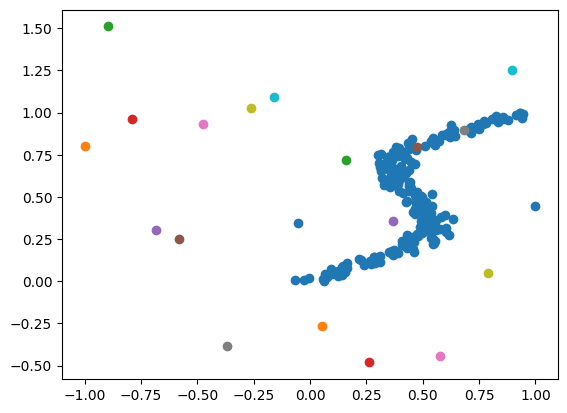

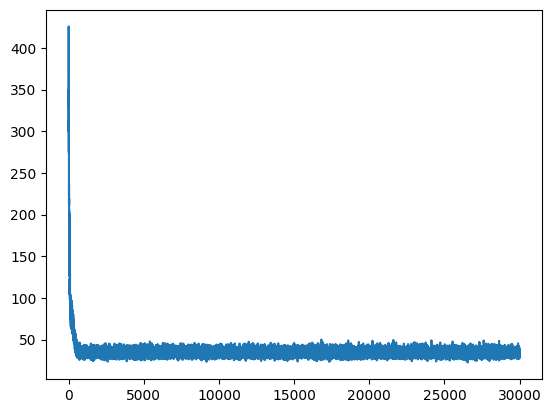

In [ ]:
# the last layer is composed of three parameters: pi, mu, sigma
class MixtureDensityNetworks:
  def __init__(self, layerShapes):  # the last layer is the number of mixtures (k)
    self.parameters = []
    for i in range(len(layerShapes) - 2):
      self.parameters.append(torch.rand(layerShapes[i+1], layerShapes[i], requires_grad=False) )
    self.wkl_pi = torch.rand(layerShapes[len(layerShapes) - 1], layerShapes[len(layerShapes) - 2], requires_grad=False)
    self.wkl_mu = torch.rand(layerShapes[len(layerShapes) - 1], layerShapes[len(layerShapes) - 2], requires_grad=False)
    self.wkl_sigma = torch.rand(layerShapes[len(layerShapes) - 1], layerShapes[len(layerShapes) - 2], requires_grad=False)
    # store:
    # aj, zi, None, wji
    # al, zj, aj, wlj
    # ak, zl, al, wkl
    self.store = np.zeros((len(self.parameters), 4)).tolist()

    self.store_pi = np.zeros(4).tolist()
    self.store_mu = np.zeros(4).tolist()
    self.store_sigma = np.zeros(4).tolist()

    self.alpha = 0.01

  def printParameters(self):
    print("=================")
    for i in self.parameters:
      print(i)
    print(self.wkl_pi)
    print(self.wkl_mu)
    print(self.wkl_sigma)
    print("=================")

  def forward(self, xi):
    for i in range(0, len(self.parameters)):
      w = self.parameters[i]
      self.store[i][3] = w

      if (i == 0):
        self.store[i][2] = None
        self.store[i][1] = xi
      else:
        self.store[i][2] = self.store[i-1][0]
        self.store[i][1] = tanh(self.store[i][2])
      self.store[i][0] = w @ self.store[i][1]

    self.store_pi[3] = self.wkl_pi
    self.store_pi[2] = self.store[-1][0]
    self.store_pi[1] = tanh(self.store_pi[2])
    self.store_pi[0] = self.wkl_pi @ self.store_pi[1]

    self.store_mu[3] = self.wkl_mu
    self.store_mu[2] = self.store[-1][0]
    self.store_mu[1] = tanh(self.store_mu[2])
    self.store_mu[0] = self.wkl_mu @ self.store_mu[1]

    self.store_sigma[3] = self.wkl_sigma
    self.store_sigma[2] = self.store[-1][0]
    self.store_sigma[1] = tanh(self.store_sigma[2])
    self.store_sigma[0] = self.wkl_sigma @ self.store_sigma[1]

    return self.store_pi[0], self.store_mu[0], self.store_sigma[0]

  def backward(self, dE_da_pi, dE_da_mu, dE_da_sigma):
    dE_dw = None
    dE_da = None

    # pi
    da_da, da_dw = getJacobians(self.store_pi[0], self.store_pi[1], self.store_pi[2], self.store_pi[3])
    dE_dw = dE_da_pi @ da_dw
    self.wkl_pi -= self.alpha * dE_dw
    dE_da = dE_da_pi @ da_da

    # mu
    da_da, da_dw = getJacobians(self.store_mu[0], self.store_pi[1], self.store_pi[2], self.store_mu[3])
    dE_dw = dE_da_mu @ da_dw
    self.wkl_mu -= self.alpha * dE_dw
    dE_da += dE_da_mu @ da_da

    # sigma
    da_da, da_dw = getJacobians(self.store_sigma[0], self.store_sigma[1], self.store_sigma[2], self.store_sigma[3])
    dE_dw = dE_da_sigma @ da_dw
    self.wkl_sigma -= self.alpha * dE_dw
    dE_da += dE_da_sigma @ da_da

    for i in range(0, len(self.store)):
      i = len(self.store) - i - 1

      da_da, da_dw = getJacobians(self.store[i][0], self.store[i][1], self.store[i][2], self.store[i][3])
      dE_dw = dE_da @ da_dw
      if (da_da != None):
        dE_da = dE_da @ da_da
      self.parameters[i] -= self.alpha * dE_dw


# biased
# 2 -> 4 -> 1
n = MixtureDensityNetworks([2, 4, 3])
loss = []

train_size = 200
def getTrainData(n):
    y = torch.linspace(0.0, 1.0, n)
    x = y + 0.3 * np.sin(2 * np.pi * y) + torch.normal(-0.05, 0.05, size=(n,))
    return x, y

x_train, y_train = getTrainData(train_size)
plt.scatter(x_train, y_train)
iters = 3000

for iter in tqdm(range(iters)):
  dE_da_pi = None
  dE_da_mu = None
  dE_da_sigma = None
  l = 0
  for i in range(0, train_size):
    x = torch.tensor([1, x_train[i]])
    # print(x)
    y = y_train[i]
    a_pi, a_mu, a_sigma = n.forward(x)

    # pi, mu, sigma
    pi = np.e**a_pi / (np.e**a_pi).sum()
    mu = a_mu
    sigma = np.e ** a_sigma

    component = -1
    # select the component
    random_integer = torch.rand(1)
    temp = 0
    for j in range(pi.shape[0]):
      temp += pi[j]
      if temp >= random_integer:
        component = j

    # predict
    if (torch.isnan(sigma[component])):
      continue
    pred = torch.normal(mean=mu[component], std=sigma[component])
    l += 0.5 * (pred - y).pow(2).sum()

    # backward
    prob_N = (2 * np.pi * sigma**2)**-0.5  *  np.e ** (-1/2 / sigma**2 * (mu-pred)**2)
    gamma = (pi * prob_N) / ((pi * prob_N).sum())
    # print(gamma)

    if (i == 0):
      dE_da_pi = pi - gamma
      dE_da_mu = gamma * ((mu - y) / sigma.pow(2))
      dE_da_sigma = gamma * (1  -  (mu - y).pow(2).sum() / sigma.pow(2))
    else:
      dE_da_pi += pi - gamma
      dE_da_mu += gamma * ((mu - y) / sigma.pow(2))
      dE_da_sigma += gamma * (1  -  (mu - y).pow(2).sum() / sigma.pow(2))
  # print(dE_da_pi)
  # print(dE_da_mu)
  # print(dE_da_sigma)
  loss.append(l)
  n.backward(dE_da_pi / train_size, dE_da_mu / train_size, dE_da_sigma / train_size)

test_size = 20
x_test = torch.linspace(-1, 1, test_size)

for i in range(0, test_size):
  xi = torch.tensor([1.0, x_test[i]])
  a_pi, a_mu, a_sigma = n.forward(x)
  # pi, mu, sigma
  pi = np.e**a_pi / (np.e**a_pi).sum()
  mu = a_mu
  sigma = np.e ** a_sigma
  component = -1
  # select the component
  random_integer = torch.rand(1)
  temp = 0
  for j in range(pi.shape[0]):
    temp += pi[j]
    if temp >= random_integer:
      component = j
  # predict
  if (torch.isnan(sigma[component])):
    print(sigma)
    continue
  pred = torch.normal(mean=mu[component], std=sigma[component])
  plt.scatter(x_test[i], pred)

plt.figure(2)
plt.plot([i for i in range(0, len(loss))], loss)

In [ ]:
n.printParameters()

tensor([[-0.2599, -0.3929],
        [ 0.8744,  0.1428],
        [ 0.0963,  0.9057],
        [ 0.1643,  0.2110]])
tensor([[ 0.1670,  0.2946,  0.6744,  0.9889],
        [ 0.3094,  0.0837, -0.0060,  0.1842],
        [ 0.1287,  0.2981,  0.8845,  0.6279]])
tensor([[ 0.6201,  0.4249,  0.5271,  0.7905],
        [ 0.7545,  0.9163,  0.2180, -0.0190],
        [ 0.0180,  0.5609, -0.0222,  0.5601]])
tensor([[ 0.2763, -0.1886, -0.5597, -0.4379],
        [ 0.6372, -0.3880,  0.2592,  0.5820],
        [ 0.4002, -0.6005, -0.3312,  0.2381]])
